In [ ]:
!unzip -qq dataset.zip

In [ ]:
!pip3 install flaxmodels -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 3.6 MB/s eta 0:00:00


In [ ]:
import os
from typing import Any
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf
from flax import linen as nn
from flax.training.train_state import TrainState
from flax.core import FrozenDict
from flaxmodels.resnet import ResNet18
import optax
import jax
import jax.numpy as jnp


from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


##### Config
BATCH_SIZE = 128
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 2
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4

#### Utilities

In [ ]:
# Dataset Utilities

# Augmentation
aug_fn = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def compute_dataset_stats(dataset):
  # Compute dataset mean and std
  n_samples = 0
  channel_sum = tf.zeros(3)
  channel_squared_sum = tf.zeros(3)

  for images, _ in dataset.unbatch():
      images = tf.cast(images, tf.float32) / 255.0
      n_samples += 1
      channel_sum += tf.reduce_mean(images, axis=[0, 1])
      channel_squared_sum += tf.reduce_mean(tf.square(images), axis=[0, 1])

  mean = channel_sum / n_samples
  std = tf.sqrt(channel_squared_sum / n_samples - tf.square(mean))
  return mean, std

# Load and preprocess dataset
def load_dataset(data_dir, mean, std, is_training=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        label_mode='int',
        shuffle=is_training,
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
    )
    ds = ds.map(lambda x, y: (((tf.cast(x, tf.float32) / 255.0) - mean) / std, y))

    if is_training:
        ds = ds.map(lambda x, y: (aug_fn(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return ds.prefetch(tf.data.AUTOTUNE)

# Generator setup with stat computation
def get_generators(path='dataset', display_sample=True):
    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(path, 'train'),
        label_mode='int',
        shuffle=False,
        batch_size=1,
        image_size=IMAGE_SIZE,
    )

    mean, std = compute_dataset_stats(raw_train_ds)
    print("Computed Mean:", mean.numpy())
    print("Computed Std:", std.numpy())

    # Convert to constants for later use in tf.data
    mean = tf.constant(mean)
    std = tf.constant(std)

    train_ds = load_dataset(os.path.join(path, 'train'), mean, std, is_training=True)
    test_ds = load_dataset(os.path.join(path, 'test'), mean, std, is_training=False)

    # Display a sample batch
    if display_sample:
        for images, labels in train_ds.take(1):
            print(f"Image batch shape: {images.shape}")
            print(f"Label batch shape: {labels.shape}")
            plt.figure(figsize=(10, 10))
            for i in range(min(9, len(images))):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(((images[i] * std) + mean).numpy().clip(0, 1))  # De-normalize for viewing
                plt.title(f"Label: {labels[i].numpy()}")
                plt.axis("off")
            plt.show()

    return train_ds, test_ds

def tfds_to_numpy_batches(tf_dataset):
    for x, y in tf_dataset:
        yield np.array(x), np.array(y)

# Define and load ResNet-18
class ResNet18FineTuned(nn.Module):
    num_classes: int

    def setup(self):
        self.backbone = ResNet18(pretrained=True, normalize=False)
        self.classifier = nn.Dense(self.num_classes)

    def __call__(self, x, train=True):
        x = self.backbone(x, train=train)
        x = self.classifier(x)
        return x

# Create trainstate subclass for batchnorm
class TrainStateWithBatchStats(TrainState):
    batch_stats: Any

# model, optimiser state initialisation
def create_train_state(rng, model, learning_rate):
    variables = model.init(rng, jnp.ones([1, *IMAGE_SIZE, 3]), train=True)
    tx = optax.adamw(learning_rate)
    return TrainStateWithBatchStats.create(
        apply_fn=model.apply,
        params=variables["params"],
        tx=tx,
        batch_stats=variables["batch_stats"]
    )

# Metrics
@jax.jit
def compute_metrics(logits, labels):
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return {"loss": loss, "accuracy": accuracy}

# One training step
@jax.jit
def train_step(state, batch_images, batch_labels):
    def loss_fn(params):
        outputs, updated_state = state.apply_fn(
            {"params": params, "batch_stats": state.batch_stats},
            batch_images,
            train=True,
            mutable=["batch_stats"],  # Mark batch_stats mutable
        )
        loss = optax.softmax_cross_entropy_with_integer_labels(outputs, batch_labels).mean()
        return loss, (outputs, updated_state)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, new_state)), grads = grad_fn(state.params)
    new_state = state.replace(
        batch_stats=new_state["batch_stats"]
    )
    state = new_state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits, batch_labels)
    return state, metrics

@jax.jit
def eval_step(state, images):
    logits = state.apply_fn(
        {"params": state.params, "batch_stats": state.batch_stats},
        images,
        train=False,
        mutable=False
    )
    return jnp.argmax(logits, axis=-1)


# Report
def plot_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=["chicken", "duck"], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(8, 4))
    sns.heatmap(report_df.iloc[:2, :-1], annot=True, cmap='Blues', cbar=True)
    plt.title("Classification Report")
    plt.yticks(rotation=0)
    plt.show()

#### Run training and eval

Found 897 files belonging to 2 classes.
Computed Mean: [0.51090807 0.5010219  0.44072625]
Computed Std: [0.2673692  0.26115635 0.2819808 ]
Found 897 files belonging to 2 classes.
Found 482 files belonging to 2 classes.
Image batch shape: (128, 224, 224, 3)
Label batch shape: (128,)


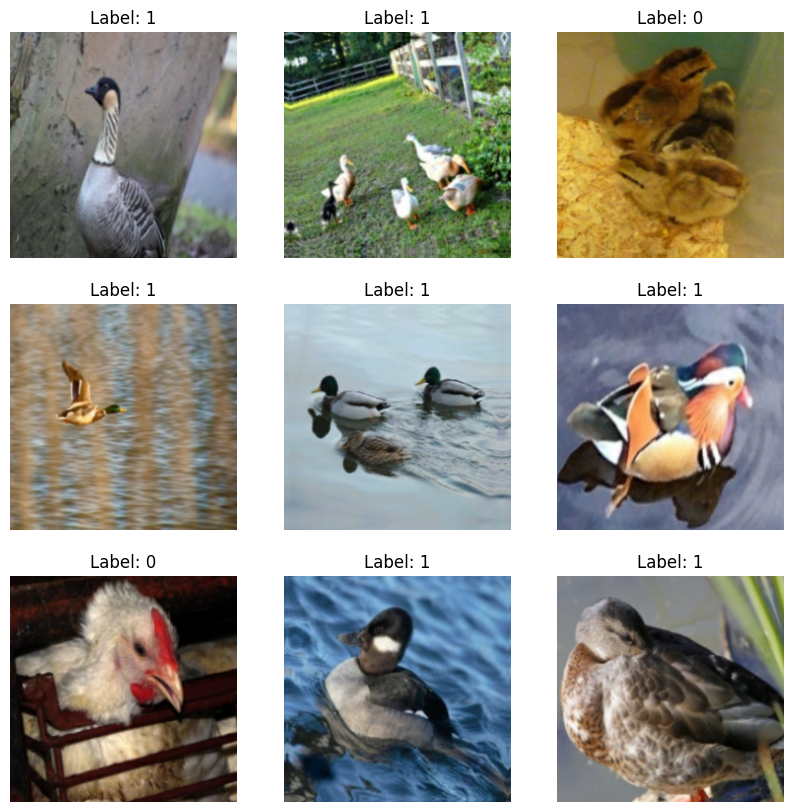

In [ ]:
# Get Dataset
train_ds, test_ds = get_generators()

In [ ]:
# Initialise model
rng = jax.random.PRNGKey(0)
model = ResNet18FineTuned(num_classes=NUM_CLASSES)
state = create_train_state(rng, model, LEARNING_RATE)


# Training
for epoch in range(NUM_EPOCHS):
    epoch_loss, epoch_acc, batch_count = 0, 0, 0

    for batch_images, batch_labels in tqdm(tfds_to_numpy_batches(train_ds), desc=f"Epoch {epoch+1}", ncols=200):
        batch_images = jnp.array(batch_images)
        batch_labels = jnp.array(batch_labels)

        state, metrics = train_step(state, batch_images, batch_labels)
        epoch_loss += metrics["loss"]
        epoch_acc += metrics["accuracy"]
        batch_count += 1

    print(f"Loss: {epoch_loss / batch_count:.4f}, Accuracy: {epoch_acc / batch_count:.4f}")


Epoch 1: 0it [00:00, ?it/s]

Loss: 0.6899, Accuracy: 0.7324


Epoch 2: 0it [00:00, ?it/s]

Loss: 0.6820, Accuracy: 0.6494


Epoch 3: 0it [00:00, ?it/s]

Loss: 0.6706, Accuracy: 0.8174


Epoch 4: 0it [00:00, ?it/s]

Loss: 0.6688, Accuracy: 0.8252


Epoch 5: 0it [00:00, ?it/s]

Loss: 0.6652, Accuracy: 0.8447


Epoch 6: 0it [00:00, ?it/s]

Loss: 0.6611, Accuracy: 0.8652


Epoch 7: 0it [00:00, ?it/s]

Loss: 0.6719, Accuracy: 0.7178


Epoch 8: 0it [00:00, ?it/s]

Loss: 0.6602, Accuracy: 0.8525


Epoch 9: 0it [00:00, ?it/s]

Loss: 0.6585, Accuracy: 0.8564


Epoch 10: 0it [00:00, ?it/s]

Loss: 0.6671, Accuracy: 0.7471


Epoch 11: 0it [00:00, ?it/s]

Loss: 0.6537, Accuracy: 0.8750


Epoch 12: 0it [00:00, ?it/s]

Loss: 0.6519, Accuracy: 0.8770


Epoch 13: 0it [00:00, ?it/s]

Loss: 0.6509, Accuracy: 0.8721


Epoch 14: 0it [00:00, ?it/s]

Loss: 0.6497, Accuracy: 0.8760


Epoch 15: 0it [00:00, ?it/s]

Loss: 0.6645, Accuracy: 0.7490


Epoch 16: 0it [00:00, ?it/s]

Loss: 0.6472, Accuracy: 0.8789


Epoch 17: 0it [00:00, ?it/s]

Loss: 0.6640, Accuracy: 0.7432


Epoch 18: 0it [00:00, ?it/s]

Loss: 0.6454, Accuracy: 0.8809


Epoch 19: 0it [00:00, ?it/s]

Loss: 0.6448, Accuracy: 0.8789


Epoch 20: 0it [00:00, ?it/s]

Loss: 0.6428, Accuracy: 0.8838


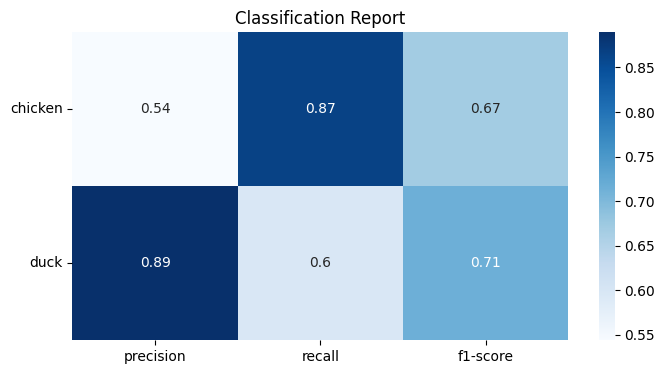

In [ ]:
# Test Evaluation
y_preds = []
y_trues = []

for batch_images, batch_labels in tfds_to_numpy_batches(test_ds):
    preds = eval_step(state, jnp.array(batch_images))
    y_preds.extend(np.array(preds))
    y_trues.extend(np.array(batch_labels))

plot_report(y_trues, y_preds)